# Enron 2.0: Predicting California's Energy Consumption

## Team Members:

**Names:** John W. Muhs, Corbett Carell
<br>**Emails:** <u0761102,u0502104>@utah.edu</br>
<br>**Github Repository:** [JohnWMuhs/2019-datascience-project](https://github.com/JohnWMuhs/2019-datascience-project "2019 Data Science Project Github Repo")</br>

## Project Objectives

In this project, we present a power consumption prediction method for the [California ISO](http://www.caiso.com/Pages/default.aspx). CAISO is California's largest Balancing Authority and Market Independent System Operator. CAISO holds a number of responsibilities and functions to ensure a competitive, cost-effective, reliabile, and environmentally friendly energy market. For example, CAISO oversees market transactions between power industry stakeholders in California such as Generation Power Plants, Transmission Owners, Renewables Integrators and Customers.  As such, CAISO closely monitors large-scale generation and consumption trends for the State of California. 

By utilizing hourly CAISO load data from the Energy Information Agency (EIA), weather data from the Darksky API. CAISO As of Milestone 1, only these data sets are used, and correlation between weather variables and load has been found, but other data sets may be included to further improve the model. 

<img src="images/CaliforniaISO_PoweringLivesEconomy.jpg">

<img src="images/CaliforniaISO_OpenTransparentMrkt.jpg">

<img src="images/CaliforniaISO_GreeningGridFutureGen.jpg">



<br>**Project Proposal (Submitted Mar. 1st):** The project was introduced via a project proposal available on Google Docs [here](https://docs.google.com/document/d/1i6FB5gmumkx5CnaKLHzKJk8nae0PirpgJDDWm3NkkZ4/edit?usp=sharing "Project Proposal").</br>

Notes from the peer review session are included in the project proposal on the last page. We have also included the project proposal in a pdf included in the Github repository. 

**Things to add from First Milestone:**
1. Weekday vs. Weekend (Done via Pandas)
2. Number of Customer Accounts ([EIA](https://www.eia.gov/opendata/qb.php?category=1718389))
3. Percent Urban Population of California ([BEA](https://apps.bea.gov/API/signup/index.cfm))
4. Gross State Product (GSP) and/or GDP of USA ([BEA](https://apps.bea.gov/API/signup/index.cfm))
5. Split the weather data into categories
6. Try PCA
7. Try a Linear Regression, kNN Regression, and simple perceptron. 
8. Use a mean error to measure accuracy of regression
9. Could use the mean error from the best model to model accuracy on the other models. 



## Data Sources
<br>**Energy Data:** [U.S. Electric System Operating Data](https://www.eia.gov/opendata/qb.php?category=2123635 "EIA API: Electric System Operating Data")</br>
<br>**Weather Data:** [Darksky API](https://darksky.net/dev "Darksky API")</br>

## Project Timeline

\<img src="images/ProjectFlowChart_Proposal.png">

## Feedback from Peer Review Session

# Section 1: Data Import

## Energy Data Import and Formatting

This section includes the code required to import power consumption from the CAISO Balancing Authority (BA) and the entire California region. The California region contains a number of BAs (the largest of which by far is CAISO), however, we decided to import both BA and region data for comparison. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import requests 
import numpy as np

pd.options.display.float_format = '{:.2f}'.format

The code below allows a user to quickly copy/paste a link from the EIA API website, and provide a title for it in the urls dictionary. The code takes that url and creates a unified dataframe. Therefore, it is incredibly easy to add additional EIA data in the future. 

In [2]:
# Import EIA API Key 
EIA_api_key = '53e6a63887dc05efe150165fa890f8da'

# Create Dictionary of urls from which we want to pull the EIA API
urls = {'CAISO_HourlyLoad':'http://api.eia.gov/series/?api_key='+EIA_api_key+'&series_id=EBA.CISO-ALL.D.H',
        'California_HourlyLoad':'http://api.eia.gov/series/?api_key='+EIA_api_key+'&series_id=EBA.CAL-ALL.D.H'}


In [3]:
# Initialize a dataframe
df = pd.DataFrame()

# Setup dummy variable to ensure that a datetime is only generated once
i = 0

for key in urls:
    
    # API pull
    EIAData = requests.get(urls[key])
    
    # Decode from utf-8
    EIAData = EIAData.content.decode("utf-8")
    
    # Load API pull as a dict
    EIAdict = json.loads(EIAData)
    
    # Access the data in EIAdict
    dfEIA = pd.DataFrame.from_dict(EIAdict['series'])
    dfEIA = dfEIA['data'][0]
    
    # Convert clean data to a dataframe
    dfEIA = pd.DataFrame(dfEIA)
    #print(dfEIA[0])
    
    # Find the datetime
    while i != 1:
        df['DateTime'] = pd.to_datetime(dfEIA[0],format='%Y%m%dT%H', errors='ignore')
        df['DateTime'] = df['DateTime'].dt.tz_convert('US/Pacific')
        i += 1
    
    # Create a new column for each type of data (url) pulled from API
    df[str(key)] = dfEIA[1]
    
# Set DateTime as index of the dataframe (tz-aware)
df.index = df['DateTime']

We decided to complete the project in a daily time resolution. This was done mainly to reduce the dataset to a reasonable size. If we kept the dataset at an hourly time resolution, we would have over 32,000 data points! However converting the data down to a daily time resolution provided a very nicely-sized 1362 data points from which to analyze. 

In [4]:
# Resample hourly data to daily data (summed energy consumption which has units of MWh)
df = df.resample('D').sum()

In [5]:
# Add a column that determines whether or not a date is a weekday or weekend day.
df['isWeekend'] = np.ones(df.shape[0]).astype(int)
df['isWeekend'] = df['isWeekend'].where((df.index.weekday == 5) | (df.index.weekday == 6),0).astype(int)

In [6]:
# Read in Customer Accounts (pulled from EIA API in file "EIA_API-MonthlyCustomerCount.ipynb")
dfCustomerAccts = pd.read_csv('CustomerAccts.csv')

# Parse DateTime from string to pandas datetime
dfCustomerAccts['DateTime'] = pd.to_datetime(dfCustomerAccts['DateTime'],format='%Y-%m-%d', errors='ignore')

# Set datetime as index
dfCustomerAccts.index = dfCustomerAccts['DateTime']

# Delete extraneous column
dfCustomerAccts = dfCustomerAccts.drop('DateTime',axis=1)

# Localize Timezone to Pacific
dfCustomerAccts = dfCustomerAccts.tz_localize('US/Pacific', level=0)

In [7]:
df = pd.merge(df,dfCustomerAccts, how='inner', left_index=True, right_index=True)

The final dataframe looks like this:

In [8]:
df.head()

,CAISO_HourlyLoad,California_HourlyLoad,isWeekend,CA_CustomerCount
DateTime,,,,
2015-07-01 00:00:00-07:00,759794.00,940489,0,15720942.00
2015-07-02 00:00:00-07:00,780410.00,962751,0,15696530.84
2015-07-03 00:00:00-07:00,719208.00,887079,0,15672119.68
2015-07-04 00:00:00-07:00,678520.00,830874,1,15647708.52
2015-07-05 00:00:00-07:00,649346.00,791310,1,15623297.35


We used the following code to export this dataframe to a csv.

In [9]:
#df.to_csv('energydata.csv')

## Weather Data (DarkSky API) Import and Format

The weather data was pulled in using the DarkSky API. The Darksky API requires inputs of latitude, longitude, and datetime to pull corresponding weather data. Darksky API does not seem to allow pulls over a date range, so for this reason, the code to pull over the entire date range required over 6,000 pulls from the API. So as not to do this every time we run the code, a separate code has been developed and included in the repository that demonstrates how DarkSky data was accessed. The code to pull the weather data can be found in "darksky-api.ipynb".

Weather data was pulled from July 1st, 2015 (constraint from EIA hourly data) to December 31st, 2018. All attributes from the DarkSky API pull have been included in the csv, so all filtering and processing will be included in this notebook. 

In [10]:
# Pull weather data from static csv
dfWeather = pd.read_csv('darksky_data.csv')

#Set dummy variable
i=0

In [11]:
# To avoid renaming multiple times and pulling an error (we could include a try except here.)
while i != 1:
    #Take the date time (originally included as a string), and format it into a pd datetime
    dfWeather['DateTime'] = pd.to_datetime(dfWeather['time'],format='%m-%d-%Y', errors='ignore')
    
    # Set Datetime as index of the dataframe
    dfWeather.index = dfWeather['DateTime']
    
    # Drop extraneous columns
    dfWeather = dfWeather.drop(['time','DateTime'],axis=1)
    
    # Set TZ to US-Pacific (both dataframes are tz-aware)
    dfWeather = dfWeather.tz_localize('US/Pacific', level=0)
    i += 1


# Section 2: Data Merge and Visualization

In [12]:
# Merge EIA and Weather dataframes. Inner only keeps the dates from the dfWeather dataframe. 
dfX = pd.merge(df,dfWeather, how='inner', left_index=True, right_index=True)

# Display head of merged dataframe
dfX.head()

,CAISO_HourlyLoad,California_HourlyLoad,isWeekend,CA_CustomerCount,apparentTemperatureHigh,apparentTemperatureLow,apparentTemperatureMax,apparentTemperatureMin,cloudCover,dewPoint,...,sunsetTime,temperatureHigh,temperatureLow,temperatureMax,temperatureMin,uvIndex,visibility,windBearing,windGust,windSpeed
DateTime,,,,,,,,,,,,,,,,,,,,,
2015-07-01 00:00:00-07:00,759794.00,940489,0,15720942.00,99.14,76.57,99.14,76.39,0.24,56.70,...,1435807466.40,98.33,76.35,98.33,76.21,9.20,8.45,191.60,13.93,1.19
2015-07-02 00:00:00-07:00,780410.00,962751,0,15696530.84,96.23,72.28,96.23,76.17,0.22,57.54,...,1435893860.60,95.88,72.22,95.88,76.04,9.80,8.40,247.40,11.84,1.94
2015-07-03 00:00:00-07:00,719208.00,887079,0,15672119.68,96.16,71.09,96.16,72.28,0.16,56.39,...,1435980253.00,96.01,71.05,96.01,72.22,10.40,8.95,254.40,11.07,2.23
2015-07-04 00:00:00-07:00,678520.00,830874,1,15647708.52,97.32,70.61,97.32,70.97,0.16,57.92,...,1436066643.40,96.99,70.60,96.99,70.95,10.20,9.02,249.20,12.00,2.38
2015-07-05 00:00:00-07:00,649346.00,791310,1,15623297.35,92.23,67.74,92.23,70.61,0.21,57.40,...,1436153032.60,92.20,67.73,92.20,70.60,9.80,9.01,247.40,12.47,3.15


In [13]:
df_pop = pd.read_csv('calpop.csv')
df_di = pd.Series(pd.date_range(start='7/1/2015', end = '12/31/2018', tz = 'US/Pacific'))
df_pop = pd.concat([df_di, df_pop], axis = 1)
df_pop['Datetime'] = df_pop[0]
df_pop.index = df_pop['Datetime']
df_pop.drop(['Date', 'Datetime', 0],axis = 1, inplace = True)

df_pop.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1280 entries, 2015-07-01 00:00:00-07:00 to 2018-12-31 00:00:00-08:00
Freq: D
Data columns (total 1 columns):
CAPOP    1280 non-null float64
dtypes: float64(1)
memory usage: 20.0 KB


In [14]:
df_gdp = pd.read_csv('bea_gdp.csv')
df_gdp = pd.concat([df_di, df_gdp], axis = 1)
df_gdp['Datetime'] = df_gdp[0]
df_gdp.index = df_gdp['Datetime']
df_gdp.drop(['Date', 'Datetime', 0],axis = 1, inplace = True)

df_gdp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1280 entries, 2015-07-01 00:00:00-07:00 to 2018-12-31 00:00:00-08:00
Freq: D
Data columns (total 1 columns):
GDP    1280 non-null float64
dtypes: float64(1)
memory usage: 20.0 KB


In [15]:
dfX = pd.concat([dfX, df_gdp, df_pop], axis=1)
dfX.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1280 entries, 2015-07-01 00:00:00-07:00 to 2018-12-31 00:00:00-08:00
Freq: D
Data columns (total 29 columns):
CAISO_HourlyLoad           1280 non-null float64
California_HourlyLoad      1280 non-null int64
isWeekend                  1280 non-null int64
CA_CustomerCount           1280 non-null float64
apparentTemperatureHigh    1279 non-null float64
apparentTemperatureLow     1279 non-null float64
apparentTemperatureMax     1280 non-null float64
apparentTemperatureMin     1280 non-null float64
cloudCover                 1280 non-null float64
dewPoint                   1280 non-null float64
humidity                   1280 non-null float64
moonPhase                  1280 non-null float64
precipIntensity            1280 non-null float64
precipIntensityMax         1280 non-null float64
precipProbability          1280 non-null float64
pressure                   1280 non-null float64
sunriseTime                1280 non-null float64
sunsetTi

In [16]:
#dropping na values and dropping California houylr_load since we will be using CASIO_hourlyload data as our depenedent variable for models
dfX = dfX.dropna()
dfX = dfX.drop(['California_HourlyLoad'], axis = 1)
dfX.tail()

,CAISO_HourlyLoad,isWeekend,CA_CustomerCount,apparentTemperatureHigh,apparentTemperatureLow,apparentTemperatureMax,apparentTemperatureMin,cloudCover,dewPoint,humidity,...,temperatureLow,temperatureMax,temperatureMin,uvIndex,visibility,windBearing,windGust,windSpeed,GDP,CAPOP
DateTime,,,,,,,,,,,,,,,,,,,,,
2018-12-27 00:00:00-08:00,568510.00,0,15703336.71,54.76,37.04,54.76,40.15,0.26,36.22,0.69,...,39.23,54.76,40.83,2.20,8.72,252.60,12.58,2.58,21255126.34,39728621.00
2018-12-28 00:00:00-08:00,575269.00,0,15710307.97,55.11,37.36,55.11,37.04,0.08,28.40,0.54,...,38.04,55.11,39.23,2.40,8.97,235.60,12.09,3.15,21260185.01,39729097.60
2018-12-29 00:00:00-08:00,550224.00,1,15717279.23,57.31,37.78,57.31,37.36,0.01,29.66,0.56,...,37.78,57.31,37.85,2.40,9.36,129.40,8.50,1.23,21265243.67,39729574.20
2018-12-30 00:00:00-08:00,534610.00,1,15724250.48,57.38,40.52,57.38,37.78,0.04,33.76,0.64,...,41.73,57.38,37.78,2.40,8.76,130.40,8.36,0.67,21270302.34,39730050.80
2018-12-31 00:00:00-08:00,559409.00,0,15731221.74,53.02,35.51,53.02,38.52,0.37,31.95,0.60,...,38.31,53.03,40.62,2.00,8.54,207.80,16.69,3.66,21275361.00,39730527.40


/anaconda3/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0,0.5,'Dew Point (Celsius)')

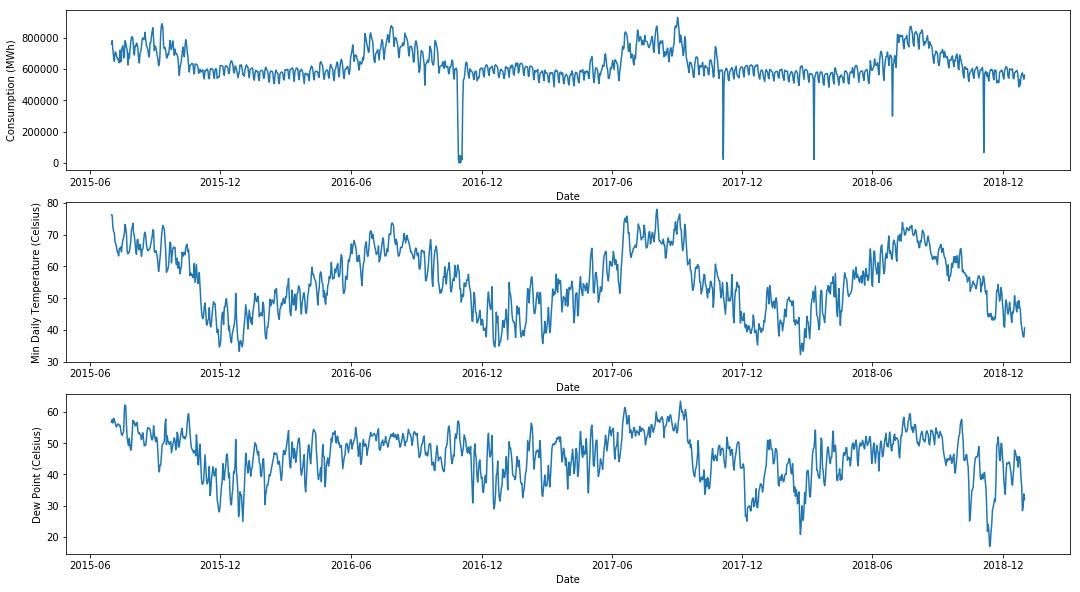

In [17]:
fig, (ax0,ax1,ax2) = plt.subplots(nrows=3, figsize=(18, 10))
#start_date = ["2016-01-01","2017-01-01","2018-01-01"]
#end_date = ["2016-12-31","2017-12-31","2018-12-31"]
 
#ax0.set_title('CAISO Consumption 2016 - 2018')
ax0.plot(dfX['CAISO_HourlyLoad'])
ax0.set_xlabel('Date')
ax0.set_ylabel('Consumption (MWh)')
ax1.plot(dfX['temperatureMin'])
ax1.set_xlabel('Date')
ax1.set_ylabel('Min Daily Temperature (Celsius)')
ax2.plot(dfX['dewPoint'])
ax2.set_xlabel('Date')
ax2.set_ylabel('Dew Point (Celsius)')

#df2017.head()

# Section 3: Data Exploration through Modeling

Here we will use a random forest to help us understand which variable are most important to determining load. This will allow us to create a new data frame with fewer variables in order to eliminate uninformative variables from our data. 

In [18]:
from sklearn.model_selection import train_test_split

training_sample2, testing_sample2 = train_test_split(dfX, test_size=0.3, random_state=42)

print("Training data set size = ", len(training_sample2))
print("Testing data set size = ", len(testing_sample2))

Training data set size =  895
Testing data set size =  384


In [19]:
train_labels = np.array(training_sample2['CAISO_HourlyLoad'])
train_features = training_sample2.drop('CAISO_HourlyLoad', axis=1)

training_sample2 = train_features
train_feature_list = list(train_features.columns)

train_features = np.array(train_features)

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 400, random_state = 42, min_impurity_decrease = 0.01)

rf.fit(train_features, train_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.01, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [20]:
print('Num of features when fit is perform')
print(rf.n_features_)
print('--------------------')
print('Num of outputs when fit is performed')
print(rf.n_outputs_)
print('--------------------')
print('Feature Importance')
print(rf.feature_importances_)

Num of features when fit is perform
27
--------------------
Num of outputs when fit is performed
1
--------------------
Feature Importance
[0.04869587 0.03186754 0.03169976 0.03572078 0.03685454 0.32018455
 0.01304663 0.0604597  0.01532467 0.02651189 0.00292436 0.0052457
 0.01102076 0.00510929 0.00795419 0.00796484 0.02074242 0.01950395
 0.02086331 0.20540617 0.00812421 0.00922799 0.01783678 0.01247623
 0.01151408 0.00717532 0.00654446]


In [21]:
from sklearn.model_selection import cross_validate

#Here we are determining the accuracy of our random forest
test_labels = np.array(testing_sample2['CAISO_HourlyLoad'])
test_features = testing_sample2.drop('CAISO_HourlyLoad', axis=1)

testing_sample2 = test_features
test_feature_list = list(test_features.columns)

test_features = np.array(test_features)

accuracy = cross_validate(rf, test_features, test_labels, cv=10)['test_score']
print('The accuracy is: ',sum(accuracy)/len(accuracy)*100,'%')

The accuracy is:  73.43630818404607 %


Text(0.5,1,'Variable Importances')

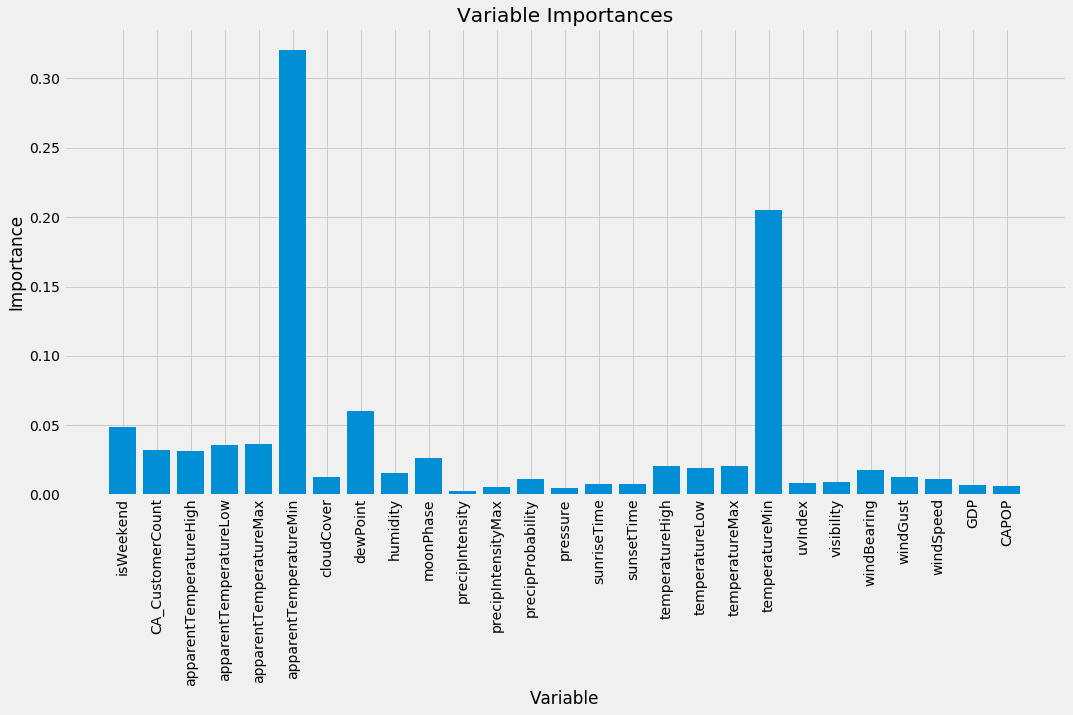

In [22]:
# Get numerical feature importances
import matplotlib.pyplot as plt

%matplotlib inline

importances = list(rf.feature_importances_)

# Set the style
plt.style.use('fivethirtyeight')
plt.figure(figsize=(16,8))

# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, train_feature_list, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances') 

Here we are using the importance of the variables to create a new dataframe of only the 10 most important variables in our data.

In [23]:
importances = pd.Series(rf.feature_importances_)
importances
names = pd.Series(train_feature_list)
names
import_df = pd.concat([importances, names], axis=1)
import_df
skim_df = import_df.sort_values(by=[0] , ascending = False) 
skim_df.reset_index(inplace = True)
del skim_df["index"]
thin_df = skim_df.loc[0:9]
print(thin_df)
df_slim = dfX[['CAISO_HourlyLoad',
               'apparentTemperatureMin',
               'temperatureMin',
               'dewPoint',
               'isWeekend',
               'apparentTemperatureMax',
               'apparentTemperatureLow',
               'CA_CustomerCount',
               'apparentTemperatureHigh',
               'moonPhase',
               'temperatureLow']]

df_slim.corr()

     0                        1
0 0.32   apparentTemperatureMin
1 0.21           temperatureMin
2 0.06                 dewPoint
3 0.05                isWeekend
4 0.04   apparentTemperatureMax
5 0.04   apparentTemperatureLow
6 0.03         CA_CustomerCount
7 0.03  apparentTemperatureHigh
8 0.03                moonPhase
9 0.02           temperatureMax


,CAISO_HourlyLoad,apparentTemperatureMin,temperatureMin,dewPoint,isWeekend,apparentTemperatureMax,apparentTemperatureLow,CA_CustomerCount,apparentTemperatureHigh,moonPhase,temperatureLow
CAISO_HourlyLoad,1.00,0.66,0.66,0.43,-0.26,0.67,0.66,0.05,0.67,0.04,0.66
apparentTemperatureMin,0.66,1.00,1.00,0.82,-0.00,0.93,0.97,0.03,0.93,0.02,0.97
temperatureMin,0.66,1.00,1.00,0.82,-0.00,0.92,0.97,0.03,0.92,0.02,0.97
dewPoint,0.43,0.82,0.82,1.00,-0.00,0.64,0.79,-0.04,0.64,0.02,0.79
isWeekend,-0.26,-0.00,-0.00,-0.00,1.00,-0.00,0.00,-0.00,-0.00,-0.01,0.00
apparentTemperatureMax,0.67,0.93,0.92,0.64,-0.00,1.00,0.94,0.06,1.00,0.00,0.94
apparentTemperatureLow,0.66,0.97,0.97,0.79,0.00,0.94,1.00,0.03,0.94,0.02,1.00
CA_CustomerCount,0.05,0.03,0.03,-0.04,-0.00,0.06,0.03,1.00,0.06,0.00,0.03
apparentTemperatureHigh,0.67,0.93,0.92,0.64,-0.00,1.00,0.94,0.06,1.00,0.00,0.94
moonPhase,0.04,0.02,0.02,0.02,-0.01,0.00,0.02,0.00,0.00,1.00,0.02


Here we are using 2 scatter plot matrices to get a visual of the interaction between our different variables.

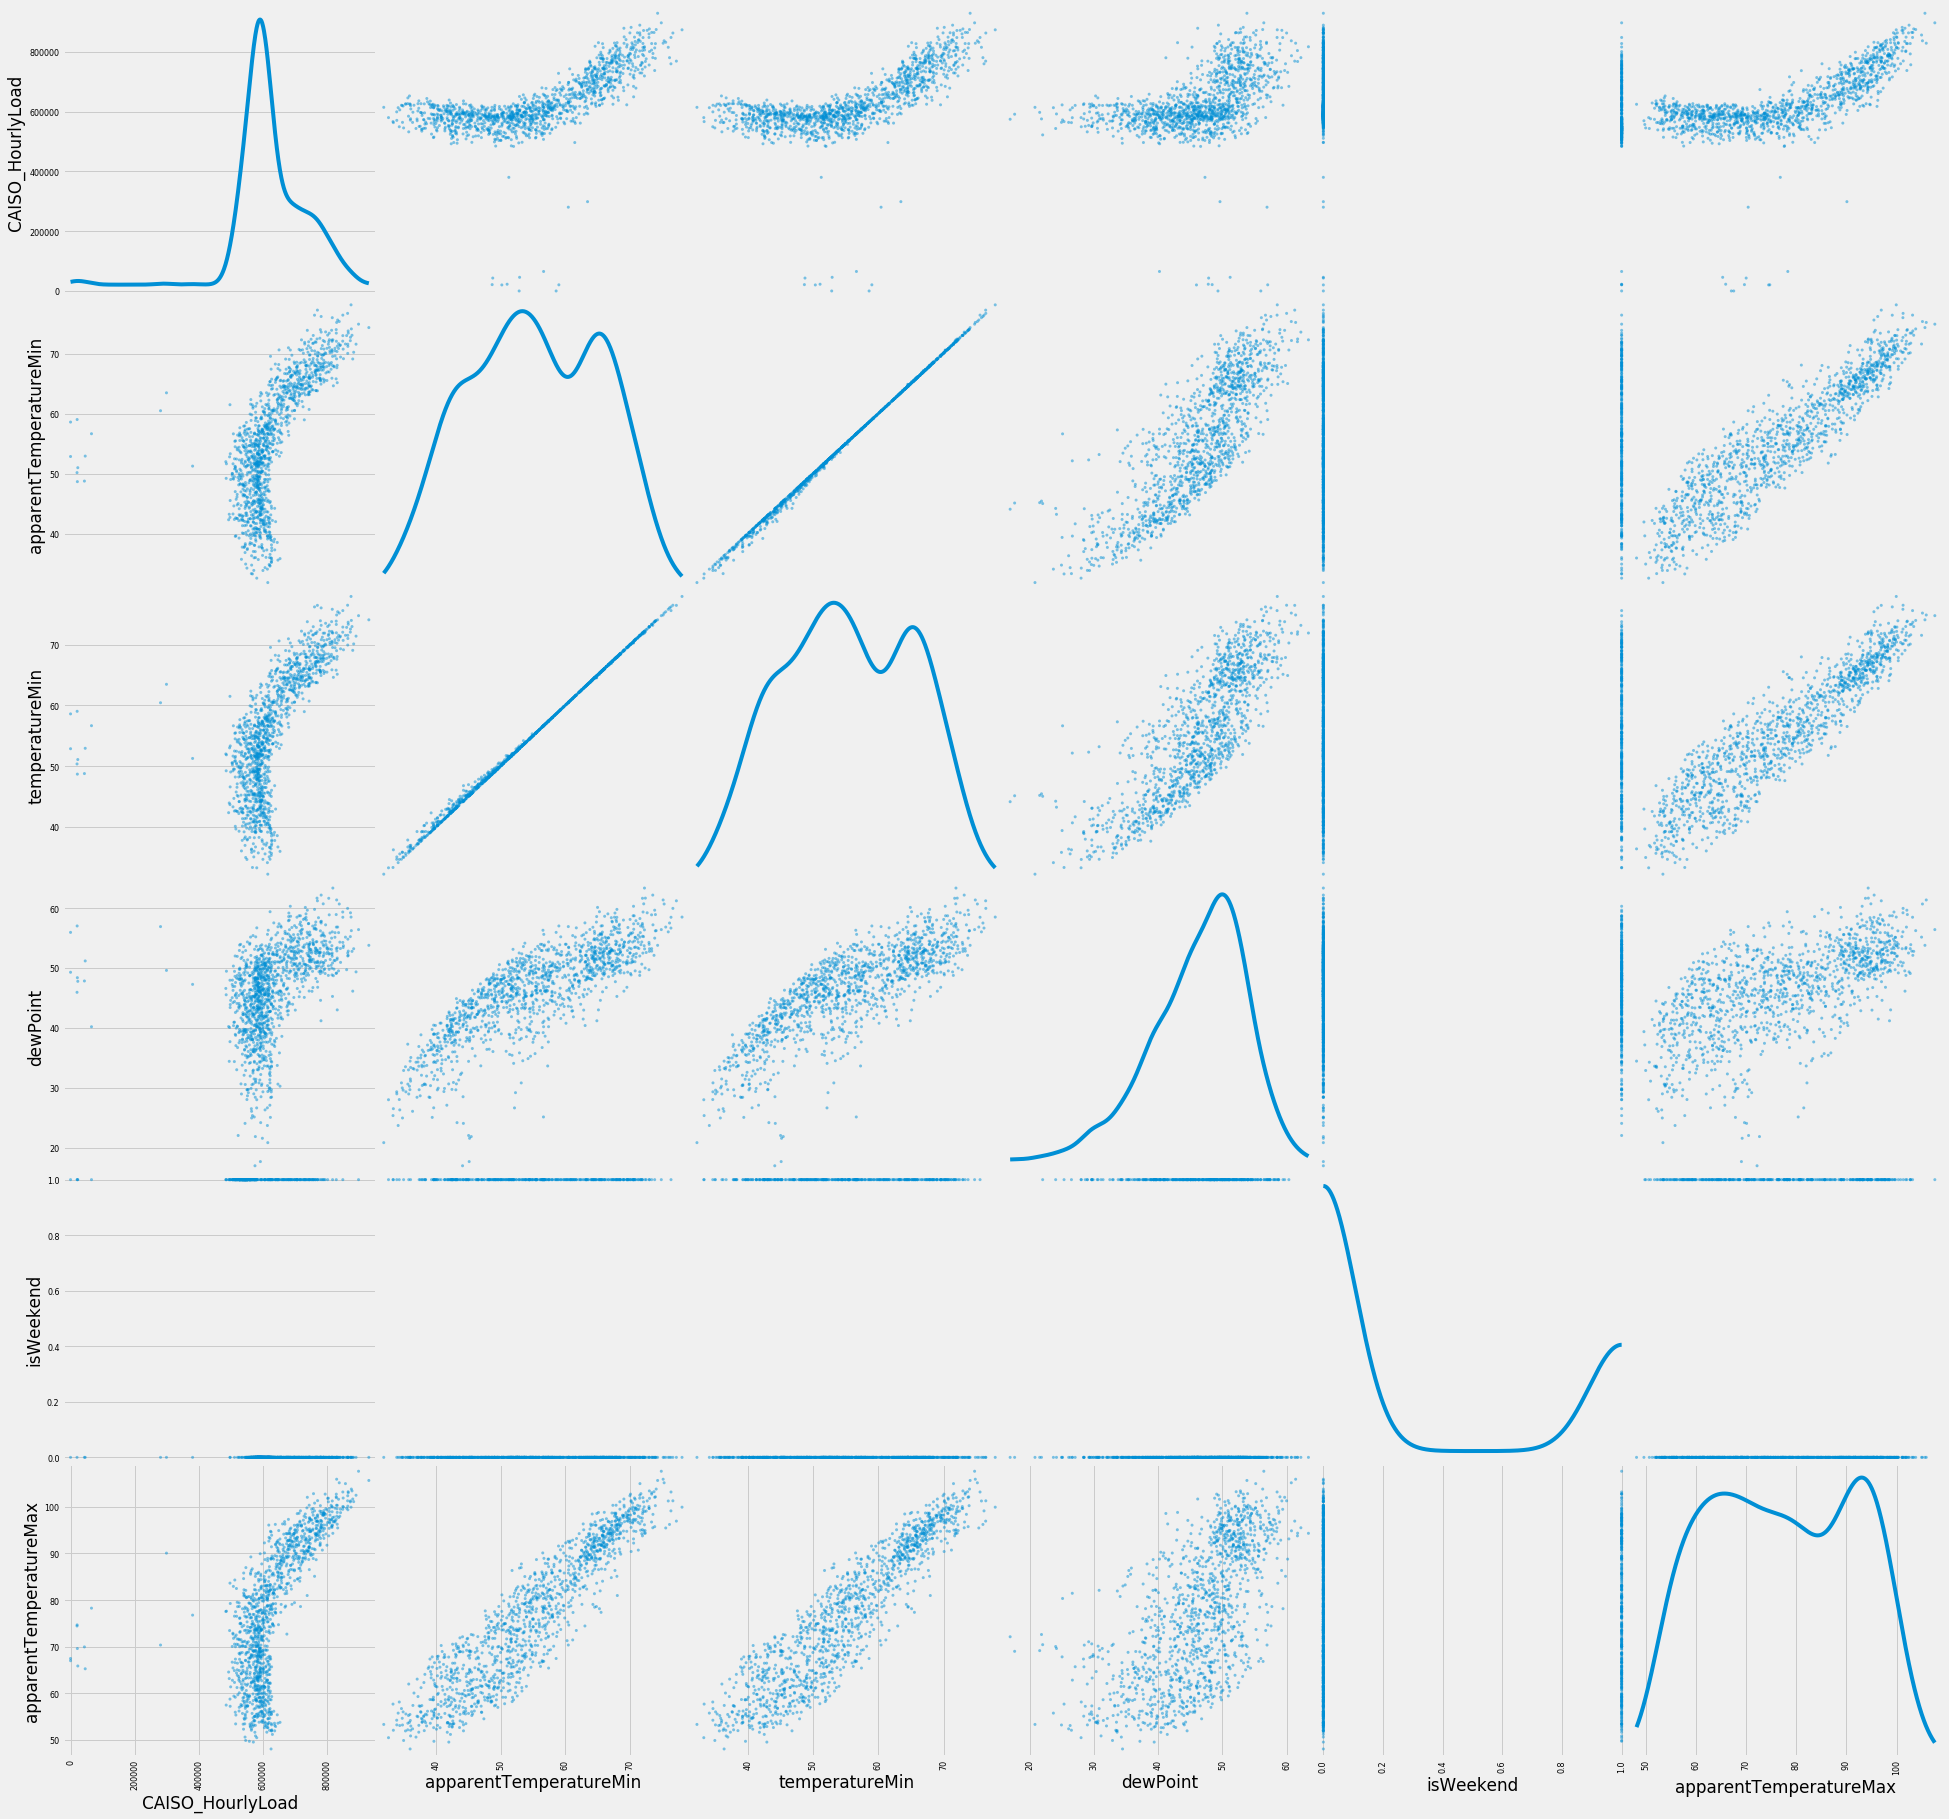

In [24]:
df_slim_1 = dfX[['CAISO_HourlyLoad',
                 'apparentTemperatureMin',
                 'temperatureMin',
                 'dewPoint',
                 'isWeekend',
                 'apparentTemperatureMax']]

pd.plotting.scatter_matrix(df_slim_1, figsize=(30, 30), diagonal='kde')
plt.show()

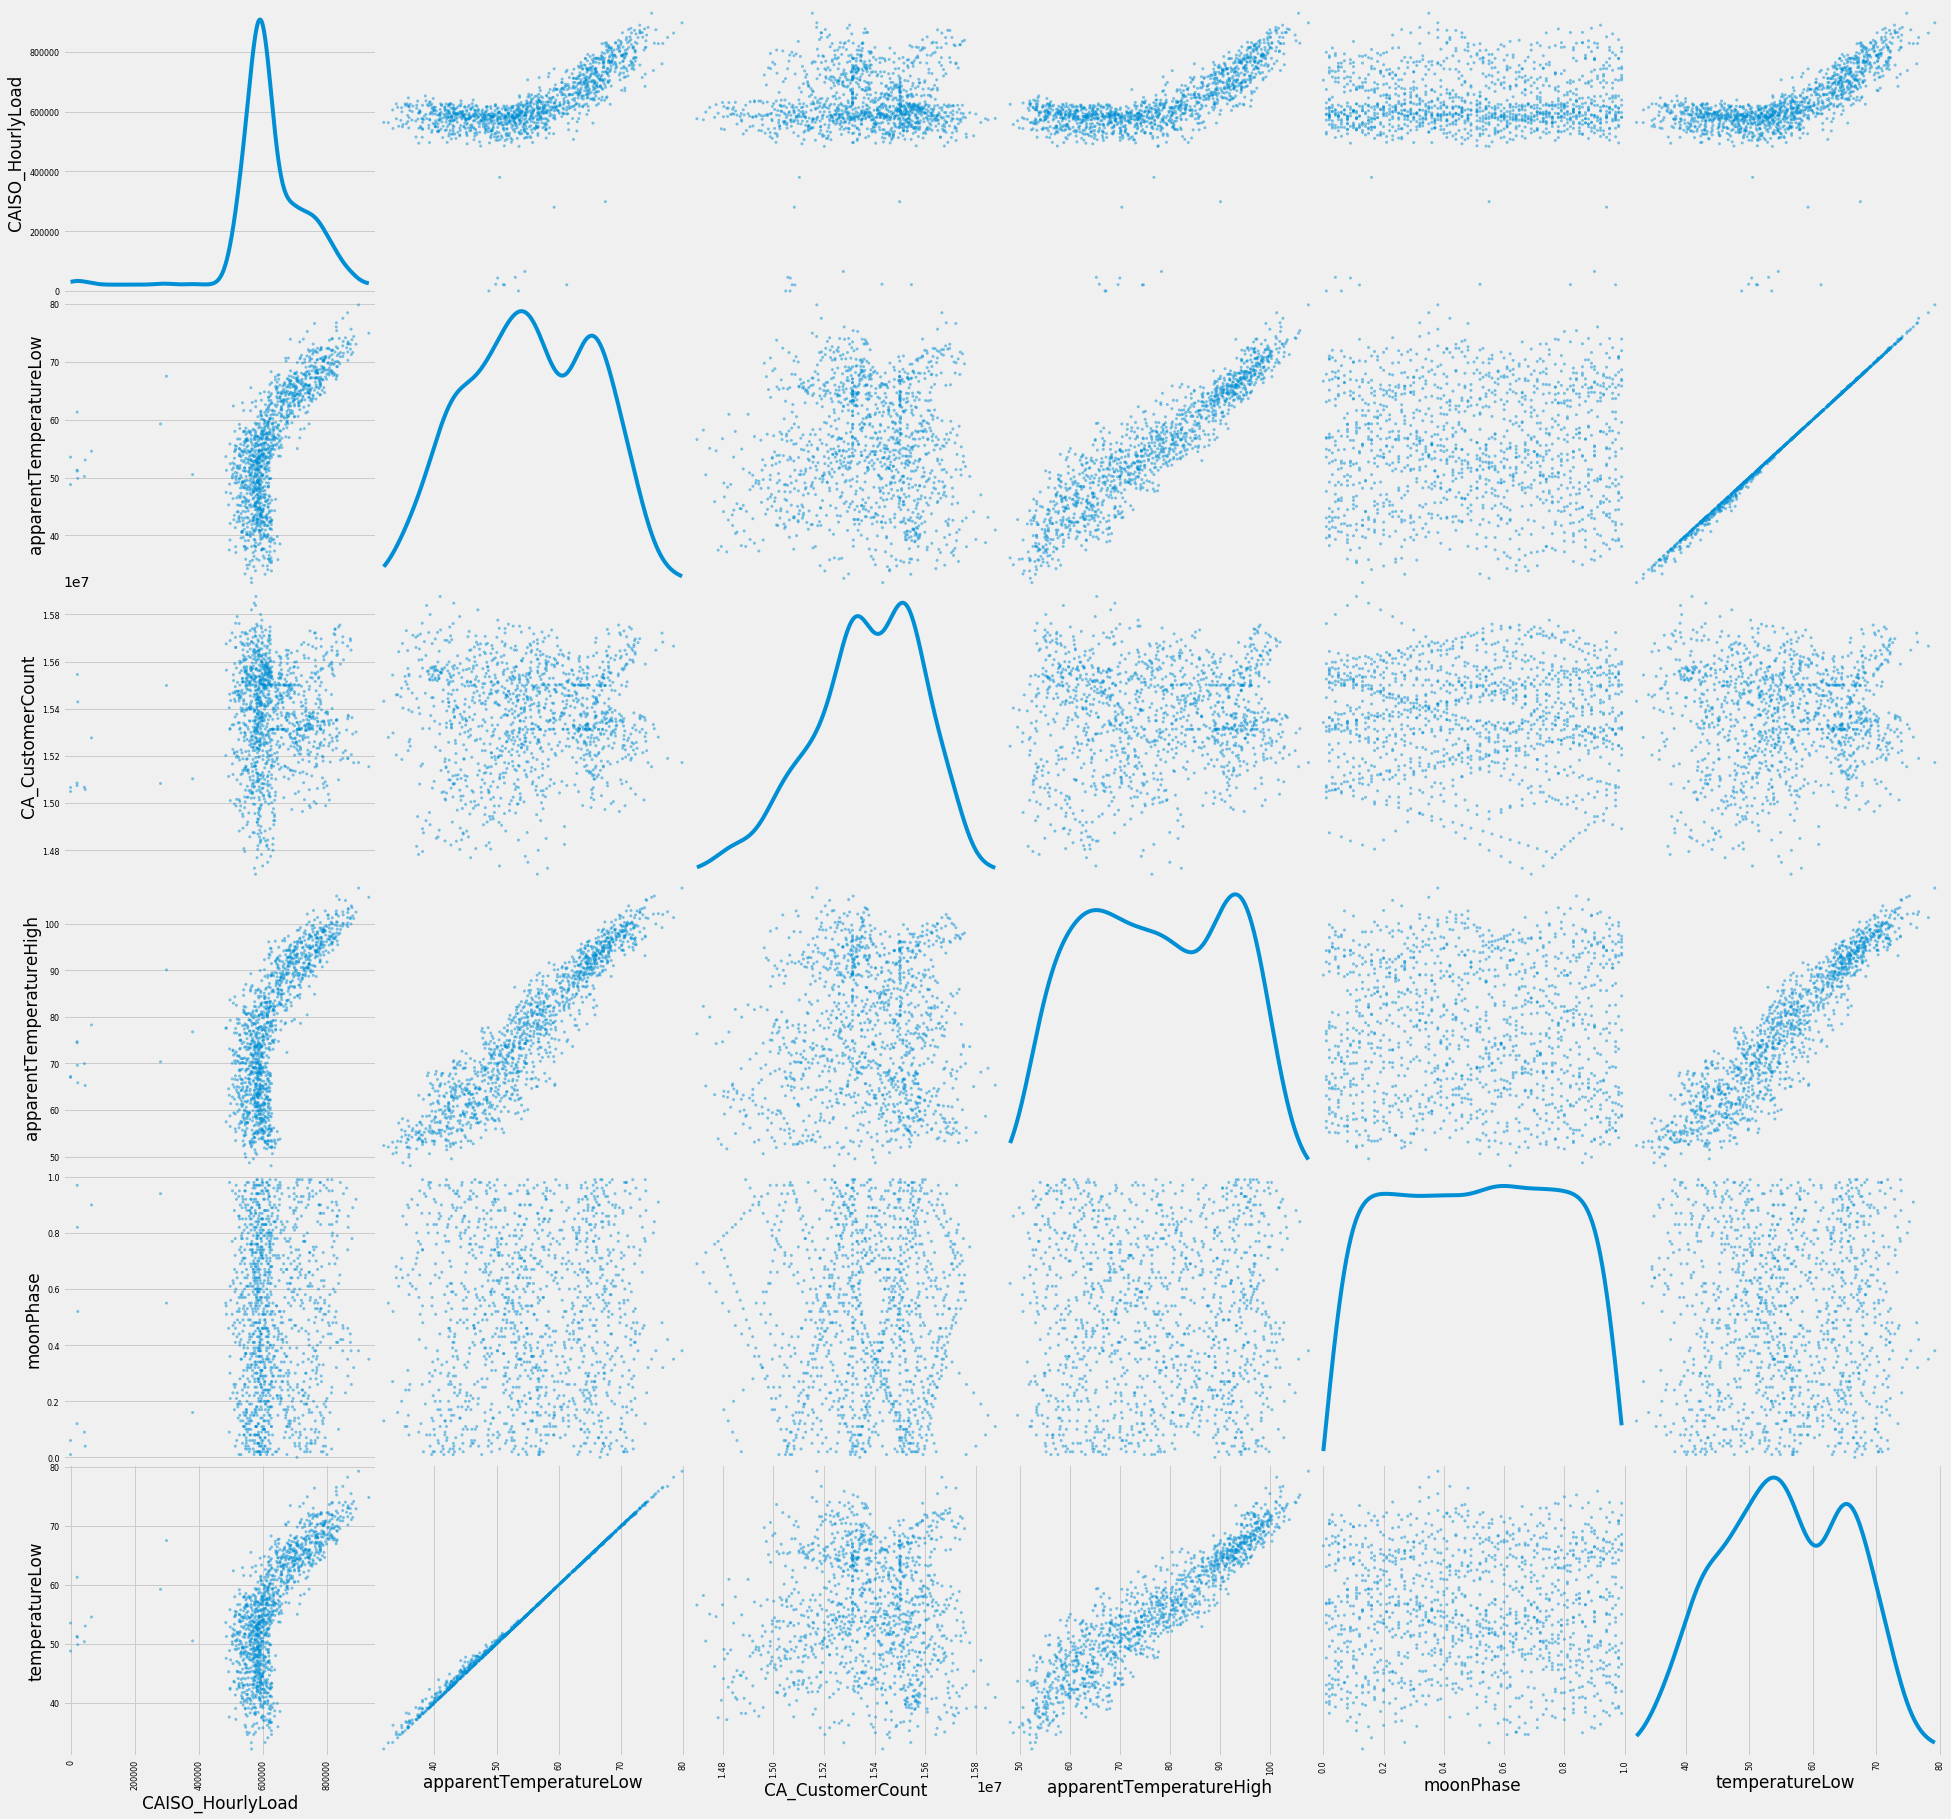

In [25]:
df_slim_2 = dfX[['CAISO_HourlyLoad',
                 'apparentTemperatureLow',
                 'CA_CustomerCount',
                 'apparentTemperatureHigh',
                 'moonPhase',
                 'temperatureLow']]

pd.plotting.scatter_matrix(df_slim_2, figsize=(30, 30), diagonal='kde')
plt.show()

In [26]:
import statsmodels.formula.api as sm

ols1 = sm.ols(formula="CAISO_HourlyLoad ~ temperatureMin + dewPoint", 
              data=dfX).fit()
ols1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       CAISO_HourlyLoad   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.470
Method:                 Least Squares   F-statistic:                     567.2
Date:                Fri, 12 Apr 2019   Prob (F-statistic):          5.69e-177
Time:                        15:12:30   Log-Likelihood:                -16140.
No. Observations:                1279   AIC:                         3.229e+04
Df Residuals:                    1276   BIC:                         3.230e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       3.179e+05   1.32e+04     24.176      0.000    2.92e+05    3.44e+05
temperatureMin  9332.5410    357.831     26.081      0.000    8630.539       1e+04
dewPoint       -4457.7453    487.568     -9.143      0.000   -5414.268   -3501.222
==============================================================================
Omnibus:                     1029.501   Durbin-Watson:                   0.552
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            35884.237
Skew:                          -3.457   Prob(JB):                         0.00
Kurtosis:                      28.011   Cond. No.                         469.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Interpretation:** I decided to use the 2 most important variables for our first regression model. We get good results for our first model. Our p-values are very low and the F-stat is very high which are both good signs that the model is statistically significant.

In [27]:
ols2 = sm.ols(formula="CAISO_HourlyLoad ~ temperatureMin", data=dfX).fit()
ols2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       CAISO_HourlyLoad   R-squared:                       0.436
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                     987.0
Date:                Fri, 12 Apr 2019   Prob (F-statistic):          5.51e-161
Time:                        15:12:30   Log-Likelihood:                -16181.
No. Observations:                1279   AIC:                         3.237e+04
Df Residuals:                    1277   BIC:                         3.238e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       2.604e+05   1.19e+04     21.856      0.000    2.37e+05    2.84e+05
temperatureMin  6652.4360    211.748     31.417      0.000    6237.025    7067.847
==============================================================================
Omnibus:                     1021.816   Durbin-Watson:                   0.516
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            36482.629
Skew:                          -3.406   Prob(JB):                         0.00
Kurtosis:                      28.262   Cond. No.                         317.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Interpretation:** By eliminating the dewPoint from the regression we see a huge increase in the F-stat for the model,  however, the R-squared dropped. These mean that the model is more statistically significant than the previous model but doesn't fit the data as well as the first. 

In [28]:
ols3 = sm.ols(formula="CAISO_HourlyLoad ~ I(temperatureMin ** 5)", data=dfX).fit()
ols3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       CAISO_HourlyLoad   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     1632.
Date:                Fri, 12 Apr 2019   Prob (F-statistic):          1.35e-230
Time:                        15:12:30   Log-Likelihood:                -16020.
No. Observations:                1279   AIC:                         3.204e+04
Df Residuals:                    1277   BIC:                         3.205e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               5.346e+05   2982.548    179.244      0.000    5.29e+05     5.4e+05
I(temperatureMin ** 5)     0.0001   3.36e-06     40.404      0.000       0.000       0.000
==============================================================================
Omnibus:                     1278.509   Durbin-Watson:                   0.654
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            78652.295
Skew:                          -4.667   Prob(JB):                         0.00
Kurtosis:                      40.266   Cond. No.                     1.42e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.42e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [29]:
ols4 = sm.ols(formula="CAISO_HourlyLoad ~ I(temperatureMin ** 5) + dewPoint + isWeekend", data=dfX).fit()
ols4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       CAISO_HourlyLoad   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                     811.6
Date:                Fri, 12 Apr 2019   Prob (F-statistic):          4.58e-295
Time:                        15:12:30   Log-Likelihood:                -15864.
No. Observations:                1279   AIC:                         3.174e+04
Df Residuals:                    1275   BIC:                         3.176e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               6.893e+05   1.34e+04     51.322      0.000    6.63e+05    7.16e+05
I(temperatureMin ** 5)     0.0002   4.38e-06     38.700      0.000       0.000       0.000
dewPoint               -3503.8705    332.277    -10.545      0.000   -4155.741   -2852.000
isWeekend              -5.708e+04   3652.187    -15.630      0.000   -6.42e+04   -4.99e+04
==============================================================================
Omnibus:                     1459.747   Durbin-Watson:                   0.638
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           132173.629
Skew:                          -5.713   Prob(JB):                         0.00
Kurtosis:                      51.473   Cond. No.                     7.24e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.24e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [30]:
ols4 = sm.ols(formula="CAISO_HourlyLoad ~ I(temperatureMin ** 7)", data=dfX).fit()
ols4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       CAISO_HourlyLoad   R-squared:                       0.567
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     1675.
Date:                Fri, 12 Apr 2019   Prob (F-statistic):          1.30e-234
Time:                        15:12:30   Log-Likelihood:                -16011.
No. Observations:                1279   AIC:                         3.203e+04
Df Residuals:                    1277   BIC:                         3.204e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               5.576e+05   2538.624    219.629      0.000    5.53e+05    5.63e+05
I(temperatureMin ** 7)  2.547e-08   6.22e-10     40.926      0.000    2.43e-08    2.67e-08
==============================================================================
Omnibus:                     1279.942   Durbin-Watson:                   0.678
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            78435.277
Skew:                          -4.677   Prob(JB):                         0.00
Kurtosis:                      40.206   Cond. No.                     5.60e+12
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.6e+12. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [31]:
ols_test = sm.ols(formula="CAISO_HourlyLoad ~ apparentTemperatureMin + I(temperatureMin ** 3) + dewPoint + isWeekend", 
              data=dfX).fit()

ols_test.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       CAISO_HourlyLoad   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     640.3
Date:                Fri, 12 Apr 2019   Prob (F-statistic):          5.45e-303
Time:                        15:12:30   Log-Likelihood:                -15842.
No. Observations:                1279   AIC:                         3.169e+04
Df Residuals:                    1274   BIC:                         3.172e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               1.025e+06   3.15e+04     32.516      0.000    9.63e+05    1.09e+06
apparentTemperatureMin -1.233e+04    978.696    -12.598      0.000   -1.42e+04   -1.04e+04
I(temperatureMin ** 3)     2.2032      0.096     22.893      0.000       2.014       2.392
dewPoint               -2353.2732    397.611     -5.919      0.000   -3133.318   -1573.228
isWeekend              -5.716e+04   3592.015    -15.912      0.000   -6.42e+04   -5.01e+04
==============================================================================
Omnibus:                     1497.730   Durbin-Watson:                   0.666
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           147302.275
Skew:                          -5.949   Prob(JB):                         0.00
Kurtosis:                      54.210   Cond. No.                     4.06e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.06e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Interpretation:** After looking at the scatter plot matrix I noticed that CAISO_HourlyLoad and temperatureMin could have an exponential relationship so I decided to test a few linear models with different exponents. By increasing the exponential power of the temperatureMin variable in the model we are able to increase both the F-stat and R-squared. One thing to note is when we increase the power to 7 is when we start to see the F-stat and R-squared begin to decrease instead of increase. A temperatureMin with a power of 6 is the best linear model I found. 

**Next Steps:** We need to use cross-validation to verify that our model is accurate and that we have not overfitted the model to the data. 

[6.40056285e-01 1.01004374e-01 1.00627586e-01 9.94147275e-02
 4.58650793e-02 6.55343799e-03 6.37739965e-03 6.37376503e-05
 3.18111496e-05 5.56241559e-06]
-------------------------------------


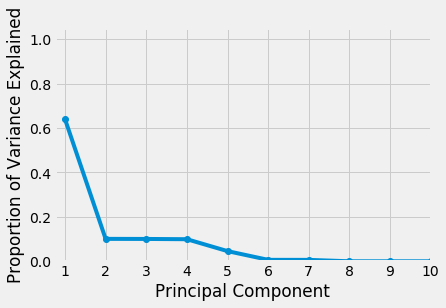

In [128]:
#PCA
from sklearn.decomposition import PCA 

x = dfX[['apparentTemperatureMin',
         'dewPoint',
         'isWeekend',
         'CA_CustomerCount',
         'moonPhase']]

pca_model = PCA()
energy_pca = pca_model.fit_transform(X_scale)

pca_df = pd.DataFrame(energy_pca, columns=['PC1', 'PC2',
                                           'PC3', 'PC4', 'PC5','PC6', 'PC7', 'PC8', 'PC9', 'PC10'])

# Variance ratio of the four principal components
var_ratio = pca_model.explained_variance_ratio_
print(var_ratio)
print('-------------------------------------')

plt.plot([1,2,3,4,5,6,7,8,9,10], var_ratio, '-o')

plt.ylabel('Proportion of Variance Explained')
plt.xlabel('Principal Component')
plt.xlim(0.75,4.25)
plt.ylim(0,1.05)
plt.xticks([1,2,3,4,5,6,7,8,9,10])
plt.show()

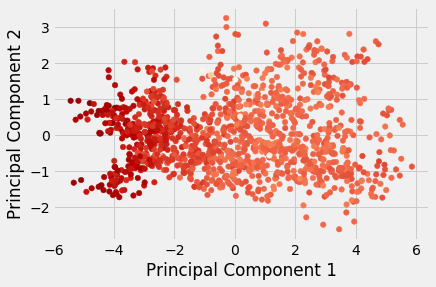

In [129]:
from matplotlib.colors import ListedColormap

cmap_ = 'OrRd'
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

y = dfX.CAISO_HourlyLoad

plt.scatter(energy_pca[:, 0], energy_pca[:, 1], c=y, cmap=cmap_, s=30)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [67]:
# pca_df.index = dfX.index
# dfPCA = pd.concat([dfX, pca_df], axis = 1)
# dfPCA.head()

In [130]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, scale 
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
from sklearn.linear_model import LinearRegression

X = dfX[['apparentTemperatureMin',
         'temperatureMin',
         'dewPoint',
         'isWeekend',
         'apparentTemperatureMax',
         'apparentTemperatureLow',
         'CA_CustomerCount',
         'apparentTemperatureHigh',
         'moonPhase',
         'temperatureLow']]

y = dfX['CAISO_HourlyLoad']

X_scale = scale(X)

X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=.3, random_state = 1)

# scale data
# scaler = StandardScaler()
# scaler.fit(X_train) # Fit only to the training data

# Apply scaling to data
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.


In [133]:
# MLP regression with Scikit-Learn
mlp_reg = MLPRegressor(hidden_layer_sizes=(100,100,100,100,100,100,100,100,100), 
                       verbose=0, 
                       random_state=2, 
                       solver='adam')
print(mlp_reg.get_params())

mlp_reg.fit(X_train, y_train)
y_pred = mlp_reg.predict(X_test)

print(mean_squared_error(y_test, y_pred))

print(mlp_reg.score(X_test,y_test)) # score = 1 is good

{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100, 100, 100, 100, 100, 100, 100, 100, 100), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 2, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
3129005028.3094954
0.6955585805672908


/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [138]:
dif = y_test - y_pred
ypred_mean = np.mean(dif)
load_mean = np.mean(dfX.CAISO_HourlyLoad)
print(ypred_mean/load_mean)

0.012777381468349995


In [132]:
# MLP regression with Scikit-Learn
mlp_reg = MLPRegressor(hidden_layer_sizes=(400,400,400,400,400), 
                       verbose=0, 
                       random_state=2, 
                       solver='adam')
print(mlp_reg.get_params())

mlp_reg.fit(X_train, y_train)
y_pred = mlp_reg.predict(X_test)

print(mean_squared_error(y_test, y_pred))

print(mlp_reg.score(X_test,y_test)) # score = 1 is good

{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (400, 400, 400, 400, 400), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 2, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
3141226385.7548447
0.6943694845529367


/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [36]:
# from sklearn.model_selection import GridSearchCV

# param_grid = [
#         {
#             'activation' : ['identity', 'logistic', 'tanh', 'relu'],
#             'solver' : ['lbfgs', 'sgd', 'adam'],
#             'hidden_layer_sizes': [
#              (1,),(2,),(3,),(4,),(5,),(6,),(7,),(8,),(9,),(10,),(11,), (12,),(13,),(14,),(15,),(16,),(17,),(18,),(19,),(20,),(21,)
#              ]
#         }
#        ]

# clf = GridSearchCV(MLPClassifier(), param_grid, cv=2,
#                            scoring='accuracy')
# clf.fit(X, y)


# print("Best parameters set found on development set:")
# print(clf.best_params_)